In [17]:
# Data
import numpy as np
import pandas as pd

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns

# Prepprc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import model_selection

# pipline
from sklearn.pipeline import make_pipeline, FeatureUnion

# ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#Metrics

from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc,accuracy_score, confusion_matrix, precision_score


In [18]:
df = pd.read_pickle('../data/clean_pass_01p1_PFemp_ident.pkl')

In [19]:
x_col = ['addr_state',
'annual_inc',
'dti',
'emp_length',
'home_ownership',
'loan_amnt',
'open_acc',
'pub_rec',
'pub_rec_bankruptcies',
'purpose',
'term',
'verification_status',
 'emp_ident']
y_col = ['target']


# redue pass 1
# 'emp_title', revist ... advanced feature engineering


In [4]:
df_x = df[x_col]
df_y = df[y_col]

In [41]:
df_x.pub_rec_bankruptcies = df_x.pub_rec_bankruptcies.astype('uint8') 
# df_x.pub_rec = df_x.pub_rec.astype('object')  - is not necessery
df_x.select_dtypes('uint8').info()
#df_x.pub_rec_bankruptcies

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38818 entries, 1 to 42474
Data columns (total 7 columns):
addr_state             38818 non-null object
home_ownership         38818 non-null object
pub_rec                38818 non-null object
purpose                38818 non-null object
term                   38818 non-null object
verification_status    38818 non-null object
emp_ident              38818 non-null object
dtypes: object(7)
memory usage: 2.4+ MB


## Feature importnace try with dummy to recall names


In [42]:
df_x_encoded = pd.get_dummies(df_x, drop_first=True)
for i in df_x_encoded.columns:
    print(i)


annual_inc
dti
emp_length
loan_amnt
open_acc
pub_rec_bankruptcies
addr_state_AL
addr_state_AR
addr_state_AZ
addr_state_CA
addr_state_CO
addr_state_CT
addr_state_DC
addr_state_DE
addr_state_FL
addr_state_GA
addr_state_HI
addr_state_IA
addr_state_ID
addr_state_IL
addr_state_IN
addr_state_KS
addr_state_KY
addr_state_LA
addr_state_MA
addr_state_MD
addr_state_ME
addr_state_MI
addr_state_MN
addr_state_MO
addr_state_MS
addr_state_MT
addr_state_NC
addr_state_NE
addr_state_NH
addr_state_NJ
addr_state_NM
addr_state_NV
addr_state_NY
addr_state_OH
addr_state_OK
addr_state_OR
addr_state_PA
addr_state_RI
addr_state_SC
addr_state_SD
addr_state_TN
addr_state_TX
addr_state_UT
addr_state_VA
addr_state_VT
addr_state_WA
addr_state_WI
addr_state_WV
addr_state_WY
home_ownership_OTHER
home_ownership_OWN
home_ownership_RENT
pub_rec_1.0
pub_rec_2.0
pub_rec_3.0
pub_rec_4.0
pub_rec_5.0
purpose_credit_card
purpose_debt_consolidation
purpose_educational
purpose_home_improvement
purpose_house
purpose_major_purchase

In [7]:
df_x_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38818 entries, 1 to 42474
Data columns (total 80 columns):
annual_inc                             38818 non-null float64
dti                                    38818 non-null float64
emp_length                             38818 non-null float64
loan_amnt                              38818 non-null float64
open_acc                               38818 non-null float64
pub_rec                                38818 non-null float64
pub_rec_bankruptcies                   38818 non-null uint8
addr_state_AL                          38818 non-null uint8
addr_state_AR                          38818 non-null uint8
addr_state_AZ                          38818 non-null uint8
addr_state_CA                          38818 non-null uint8
addr_state_CO                          38818 non-null uint8
addr_state_CT                          38818 non-null uint8
addr_state_DC                          38818 non-null uint8
addr_state_DE                          

In [8]:
df_x_encoded.addr_state_WY.value_counts()

0    38739
1       79
Name: addr_state_WY, dtype: int64

## create pipline parts for DF use

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)
            
 

In [44]:
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=df_x_encoded.columns),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector('float64'),
            StandardScaler()
        )),
        ("bool_features", make_pipeline(
            TypeSelector('uint8'),
        )),
        #("categorical_features", make_pipeline(
        #    TypeSelector("category"),
        #    OneHotEncoder()
        #)),
    ]))

In [24]:
preprocess_pipeline.fit(df_x_encoded)
X_transformed = preprocess_pipeline.transform(df_x_encoded)    
print(X_transformed.shape)
print(df_x_encoded.shape)
df_y.shape
#df_y.values

(38818, 84)
(38818, 84)


(38818, 1)

In [45]:
# Using Random Forest to gain an insight on Feature Importance
clf = DecisionTreeClassifier()
#clf = RandomForestClassifier(n_estimators=6,max_leaf_nodes=2)
clf.fit(X_transformed, df_y)
importance = clf.feature_importances_


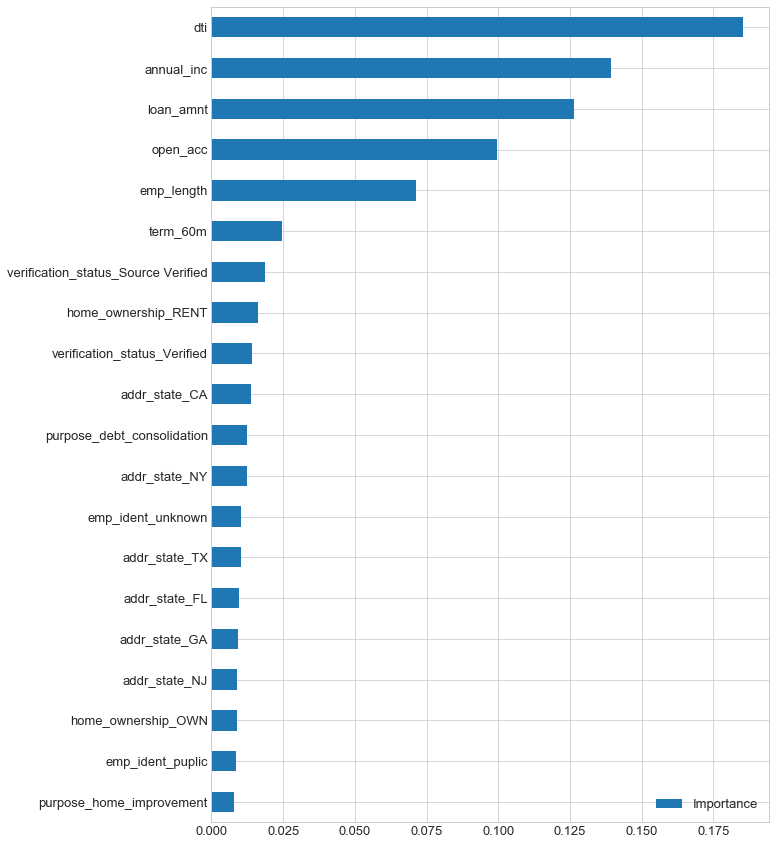

In [46]:
plt.style.use('seaborn-whitegrid')
importance = pd.DataFrame(importance, index=df_x_encoded.columns, columns=["Importance"])
importance = importance.sort_values(['Importance'], ascending=True)
plt.rc('font', size=13)
importance.tail(n=20).plot(kind='barh', figsize=(10,15));

In [47]:
## TODO merge the dummys to one importnace ... 
importance_join = pd.DataFrame(index = df_x.columns)
for i1 in df_x.select_dtypes('object').columns:
    #print(i1)
    t_sum = 0
    for i2 in importance.index:
        if i1 in i2:
            #print ('--' + i2)
            t_sum += importance.loc[i2,'Importance']
    
    importance_join.loc[i1,'Importance'] = t_sum
            
for i in df_x.select_dtypes(np.number).columns:
    importance_join.loc[i,'Importance'] = importance.loc[i,'Importance']
    
importance_join = importance_join.sort_values(['Importance'], ascending=True)

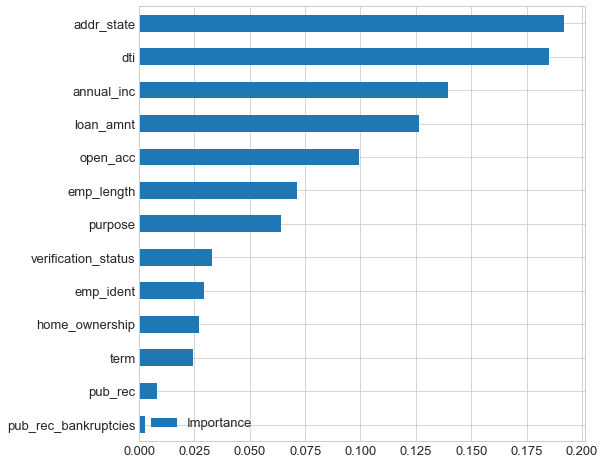

In [48]:
importance_join.plot(kind='barh', figsize=(8,8));

In [15]:
print(precision_score(df_y.values, clf.predict(X_transformed)))
accuracy_score(df_y, clf.predict(X_transformed))

1.0


1.0

In [16]:
confusion_matrix(df_y, clf.predict(X_transformed))

array([[ 5842,     0],
       [    0, 32976]])

In [26]:
y = df_y.values
y

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [27]:
## more model testing
clf = LogisticRegression()
clf.fit(X_transformed, y)
print(confusion_matrix(y, clf.predict(X_transformed)))
print(precision_score(y, clf.predict(X_transformed)))

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[  130  5712]
 [  120 32856]]
0.851897946484132


/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
## more model testing
#clf = SVC()
#clf.fit(X_transformed, df_y.values)
#print(confusion_matrix(df_y.values, clf.predict(X_transformed)))
#print(precision_score(df_y.values, clf.predict(X_transformed)))

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [32]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_transformed, y, test_size=0.33, random_state=42, stratify=
                                                                    y)

In [46]:
#clf = LogisticRegression()
clf = RandomForestClassifier(criterion='entropy',verbose=1)
clf.fit(X_train, y_train)
print(confusion_matrix(y_test, clf.predict(X_test)))
print(precision_score(y_test, clf.predict(X_test)))

/Users/arnescheunemann/opt/anaconda3/envs/nf2/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[[   33  1895]
 [   43 10839]]
0.8511858017904822


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished


In [39]:
clf.n_estimators

100

In [44]:
clf.max_leaf_nodes